# Wine

## Required Packages

In [60]:
import random
import math
import collections
import string

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from yellowbrick.regressor import PredictionError
from xgboost.sklearn import XGBRegressor

seed = 42
random.seed(seed)
np.random.seed(42)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/austindoolittle/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/austindoolittle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read and Split Data

In [2]:
# Read the data
df = pd.read_csv('./data/winemag-data-130k-v2.csv')
print(f'Columns: {list(df.columns)}')
print(f'N Rows: {len(df.index)}')

# split it into train, dev, and test
# courtesy of https://stackoverflow.com/a/38251063
perm = np.random.permutation(df.index)
m = len(df.index)

train_percent = .6
dev_percent = .2

train_end = int(m * train_percent)
dev_end = int(m * dev_percent) + train_end

train_df = df.iloc[perm[:train_end]]
dev_df = df.iloc[perm[train_end:dev_end]]
test_df = df.iloc[perm[dev_end:]]

print(f'Train shape: {train_df.shape}')
print(f'Dev shape: {dev_df.shape}')
print(f'Test shape: {test_df.shape}')

Columns: ['Unnamed: 0', 'country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery']
N Rows: 129971
Train shape: (77982, 14)
Dev shape: (25994, 14)
Test shape: (25995, 14)


## Initial Investigation
Let's start by just looking at the data and seeing what pops out to us. We'll spend a little time looking at the continuous values points and price, and then spend more time looking at the words

In [3]:
train_df.describe(include='all')

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
count,77982.000000,77943,77982,55330,77982.000000,72568.000000,77943,65329,30329,62232,59215,77982,77981,77982
unique,NaN,42,74320,27151,NaN,NaN,393,1146,17,19,15,73824,644,14410
top,NaN,US,"Cigar box, café au lait, and dried tobacco aro...",Reserve,NaN,NaN,California,Napa Valley,Central Coast,Roger Voss,@vossroger,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Pinot Noir,Wines & Winemakers
freq,NaN,32688,3,1247,NaN,NaN,21743,2670,6736,15417,15417,7,7942,140
mean,64948.374048,NaN,NaN,NaN,88.450155,35.465274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,37442.642506,NaN,NaN,NaN,3.046516,41.103730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,32697.250000,NaN,NaN,NaN,86.000000,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,64754.000000,NaN,NaN,NaN,88.000000,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,97368.000000,NaN,NaN,NaN,91.000000,42.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Points

It appears that the points are located between 80-100. This matches up with the source of the data that claims they do not publish reviews for any wine scored less than 80. More information on wine scoring can be viewed [here](https://www.winespectator.com/articles/scoring-scale)

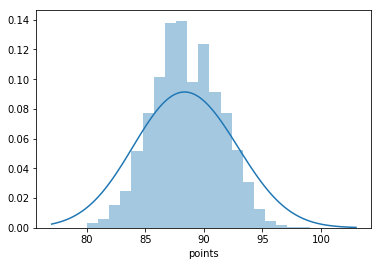

In [4]:
_ = sns.distplot(train_df.points, bins=21, kde_kws={'bw':1})

So it looks like this is a textbook normal distribution with an incredibly slight left skew. Let's just make sure that every value is represented.

In [5]:
print(np.sort(train_df.points.unique()))

[ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100]


Any missing values?

In [6]:
train_df.points.isna().sum()

0

### Price

Since this is related to currency, I bet my lunch this is a heavy tailed distribution. Let's see.

Missing values: 5414


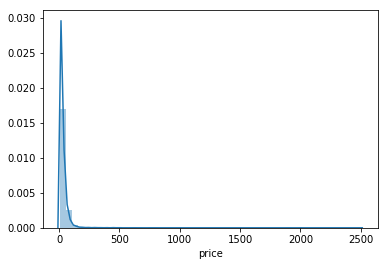

In [7]:
print(f'Missing values: {train_df.price.isna().sum()}')

# let's remove the missing prices for now
sns.distplot(train_df[~train_df.price.isna()].price)

Nice... lets log scale this.

/Users/austindoolittle/miniconda3/envs/jupyter3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


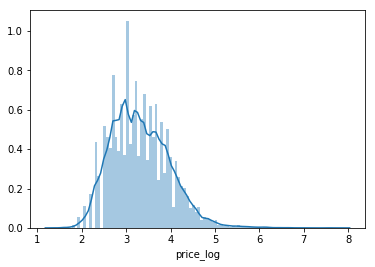

In [8]:
train_df['price_log'] = np.log(train_df.price)
ax = sns.distplot(train_df[~train_df.price_log.isna()].price_log, bins=100)

Just out of curiosity, I see that the lowest price is 4 dollars... what's the score on those?

In [9]:
train_df[train_df.price == 4].points.mean()

84.2

### String Columns

In [10]:
non_cont_columns = train_df.columns[train_df.dtypes == np.object]
print(f'Non-Continuous columns: {list(non_cont_columns)}')

Non-Continuous columns: ['country', 'description', 'designation', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery']


Let's start by focusing on the descriptions. We'll tokenize, canonize, construct a vocabulary, and finally get counts for each of the items.

In [11]:
counter = collections.Counter()

for s in train_df.description:
    s = s.lower()
    tokenized = nltk.tokenize.word_tokenize(s)
    counter.update(tokenized)

vocab = counter.items()
print(len(vocab))

36549


In [12]:
# view most common words 
most_common = counter.most_common(25)
print(most_common)

[(',', 263906), ('.', 211815), ('and', 208570), ('the', 132532), ('a', 107459), ('of', 103735), ('with', 72428), ('this', 68444), ('is', 58357), ('it', 51575), ('wine', 48002), ('flavors', 37378), ('in', 37299), ('to', 33333), ("'s", 30781), ('on', 27408), ('fruit', 26915), ('that', 24104), ('aromas', 23667), ('palate', 22850), ('acidity', 21095), ('finish', 20846), ('from', 19509), ('but', 18574), ('tannins', 18493)]


One very interesting thing viewed here is that in the most common words are very wine specific words. This is pretty obvious in hindsight, but it made me laugh to see wine just outside of the top 10.

### Tasters
Now let's look at the tasters. We'll see how many there are, and the distribution of the number of reviews each has given

19 Tasters: ['Joe Czerwinski', 'Roger Voss', 'Michael Schachner', 'Jim Gordon', 'Paul Gregutt', 'Kerin O’Keefe', 'Matt Kettmann', 'Anna Lee C. Iijima', 'Sean P. Sullivan', 'Lauren Buzzeo', 'Virginie Boone', 'Mike DeSimone', 'Anne Krebiehl\xa0MW', 'Carrie Dykes', 'Susan Kostrzewa', 'Jeff Jenssen', 'Alexander Peartree', 'Fiona Adams', 'Christina Pickard']


/Users/austindoolittle/miniconda3/envs/jupyter3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


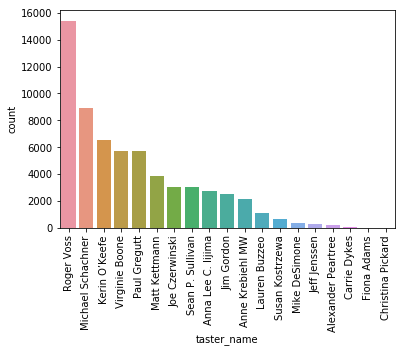

In [13]:
tasters = train_df.taster_name.dropna().unique()
print(f'{len(tasters)} Tasters: {list(tasters)}')
train_df.taster_name = train_df.taster_name.astype('category')

taster_counts  = train_df.taster_name.value_counts()
ax = sns.countplot(train_df.taster_name, order=taster_counts.index)
_ = ax.set_xticklabels(taster_counts.index, rotation=90)

As expected, there appears to be a Zeta distribution in the contributions of each taster. Let's what the numbers are on the 3 least active contributors: Carrie Dykes, Fiona Adams, and Christina Pickard.

In [14]:
print(taster_counts[['Carrie Dykes', 'Fiona Adams', 'Christina Pickard']])

Carrie Dykes         79
Fiona Adams          19
Christina Pickard     4
Name: taster_name, dtype: int64


We'll need to keep this in mind for subsequent analysis since the data related to their contributions will likely not be as representative as someone on the center or left of the distribution

#### Taster Vocabulary
Just for funsies, let's look at the vocabulary of each individual taster

In [15]:
taster_vocabs = {n: collections.Counter() for n in tasters}

for _, row in train_df[~train_df.taster_name.isna()].iterrows():
    taster = row.taster_name
    s = row.description
    s = s.lower()
    tokenized = nltk.tokenize.word_tokenize(s)
    taster_vocabs[taster].update(tokenized)

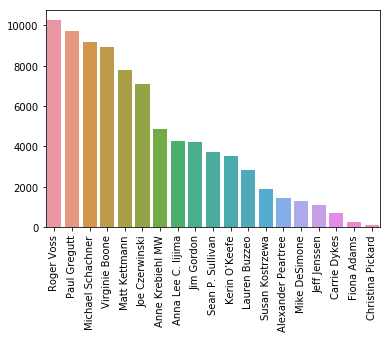

In [16]:
taster_vocab_lens = {k: len(v.items()) for k, v in taster_vocabs.items()}
taster_vocab_lens = pd.Series(taster_vocab_lens).sort_values().iloc[::-1]

ax = sns.barplot(x=taster_vocab_lens.index, y=taster_vocab_lens)
_ = ax.set_xticklabels(taster_vocab_lens.index, rotation=90)

As expected, Roger Voss is up top since he has had the most opportunity to use unique words. Let's compare the two lists.

In [17]:
compare_list = []

contribution_count_list = list(taster_counts.index)

print('Vocab Size compared to Contribution:')
for vocab_idx, taster in enumerate(taster_vocab_lens.index):
    count_idx = contribution_count_list.index(taster)
    diff = count_idx - vocab_idx
    print(f'\t{vocab_idx + 1}: {taster} ({diff:+d})')

Vocab Size compared to Contribution:
	1: Roger Voss (+0)
	2: Paul Gregutt (+3)
	3: Michael Schachner (-1)
	4: Virginie Boone (+0)
	5: Matt Kettmann (+1)
	6: Joe Czerwinski (+1)
	7: Anne Krebiehl MW (+4)
	8: Anna Lee C. Iijima (+1)
	9: Jim Gordon (+1)
	10: Sean P. Sullivan (-2)
	11: Kerin O’Keefe (-8)
	12: Lauren Buzzeo (+0)
	13: Susan Kostrzewa (+0)
	14: Alexander Peartree (+2)
	15: Mike DeSimone (-1)
	16: Jeff Jenssen (-1)
	17: Carrie Dykes (+0)
	18: Fiona Adams (+0)
	19: Christina Pickard (+0)


Kerin O'Keefe appears to be relatively bland in her word usage. 

#### Taster Score Distribution
Let's look at each reviewer's score distribution to make sure we don't have any biased reviewers

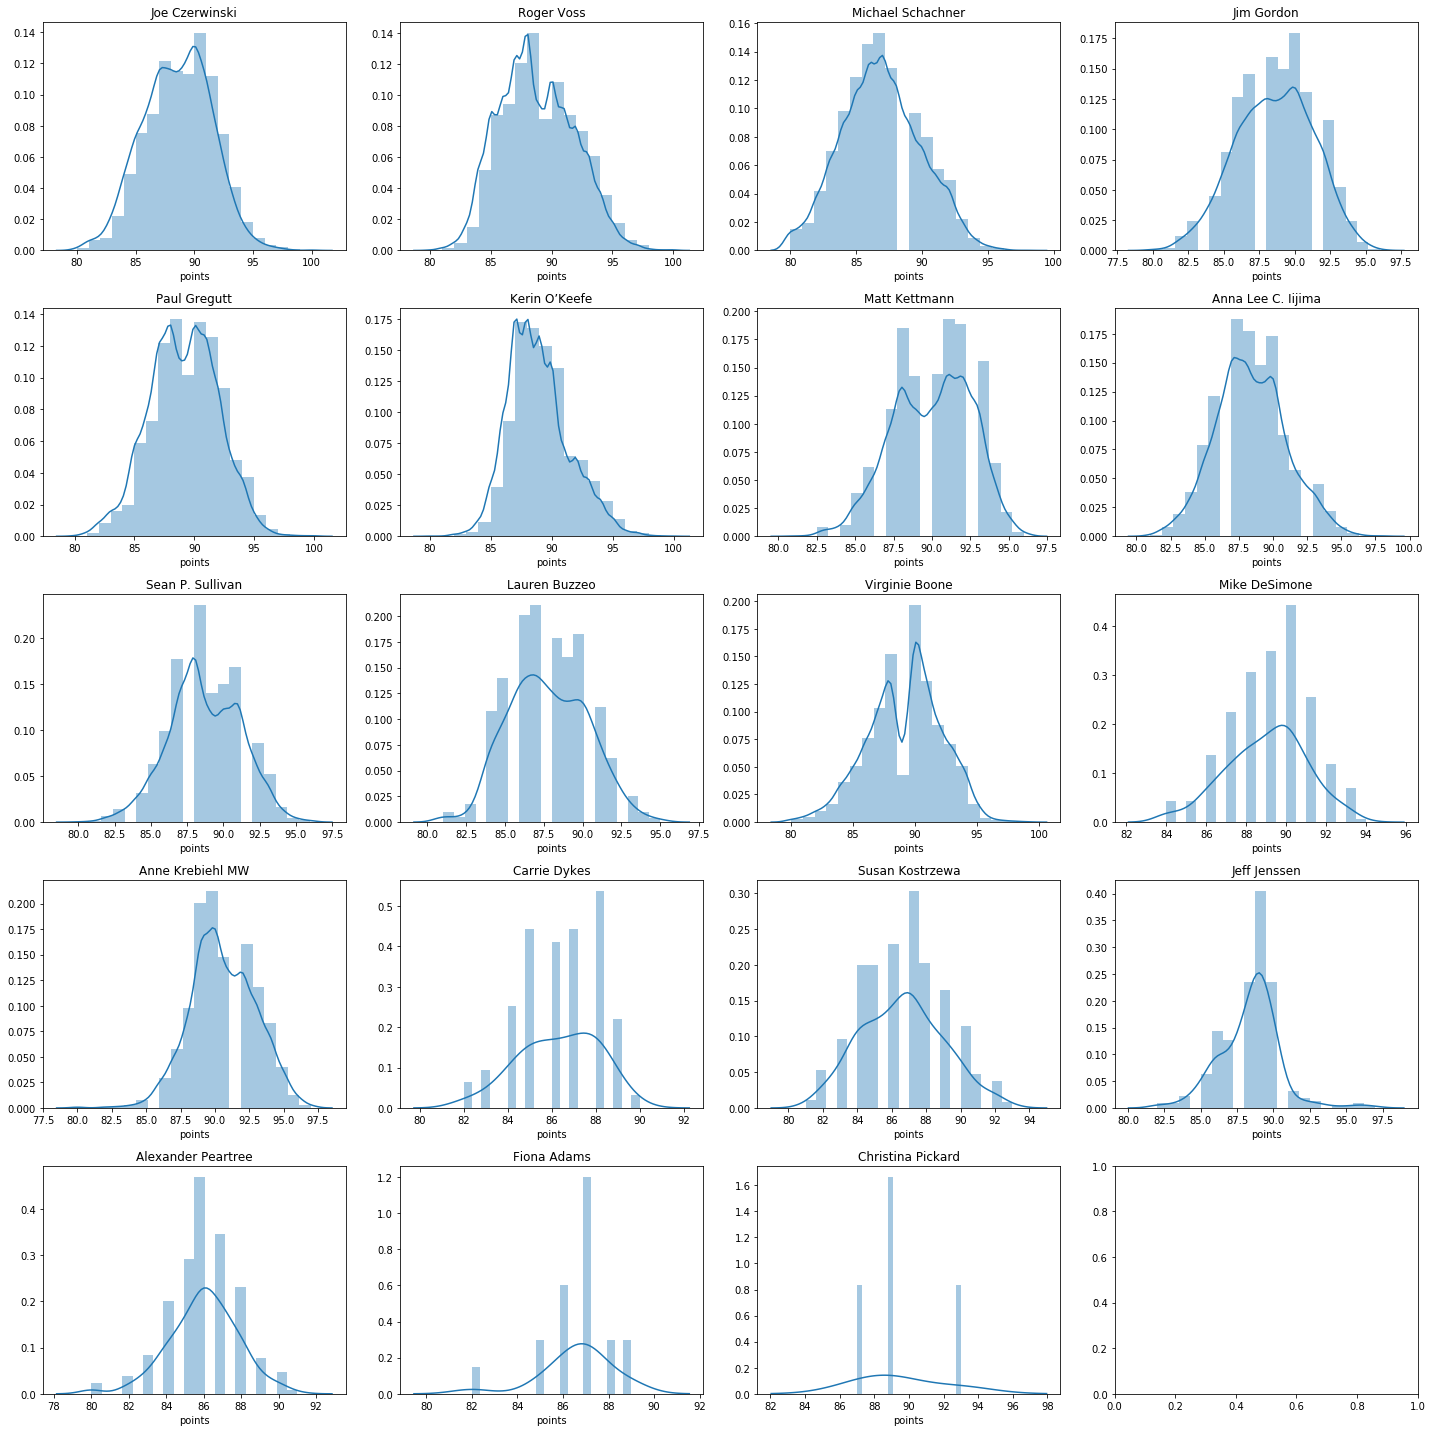

In [18]:
cols = 4
rows = math.ceil(len(tasters) / float(cols))
figs, axes = plt.subplots(rows, cols, figsize=(20,20))
axes = axes.flatten()
for taster, ax in zip(tasters, axes):
    taster_reviews = train_df[train_df.taster_name == taster]
    ax = sns.distplot(taster_reviews.points, ax=ax, bins=20)
    ax.set_title(taster)

plt.tight_layout()

There isn't any bias immediately apparent for any of the reviewers, although this is difficult to ascertain due to the large range in the number of reviews per taster.

#### Taster Price Distribution

And now let's look at the distribution of the log price for each reviewer

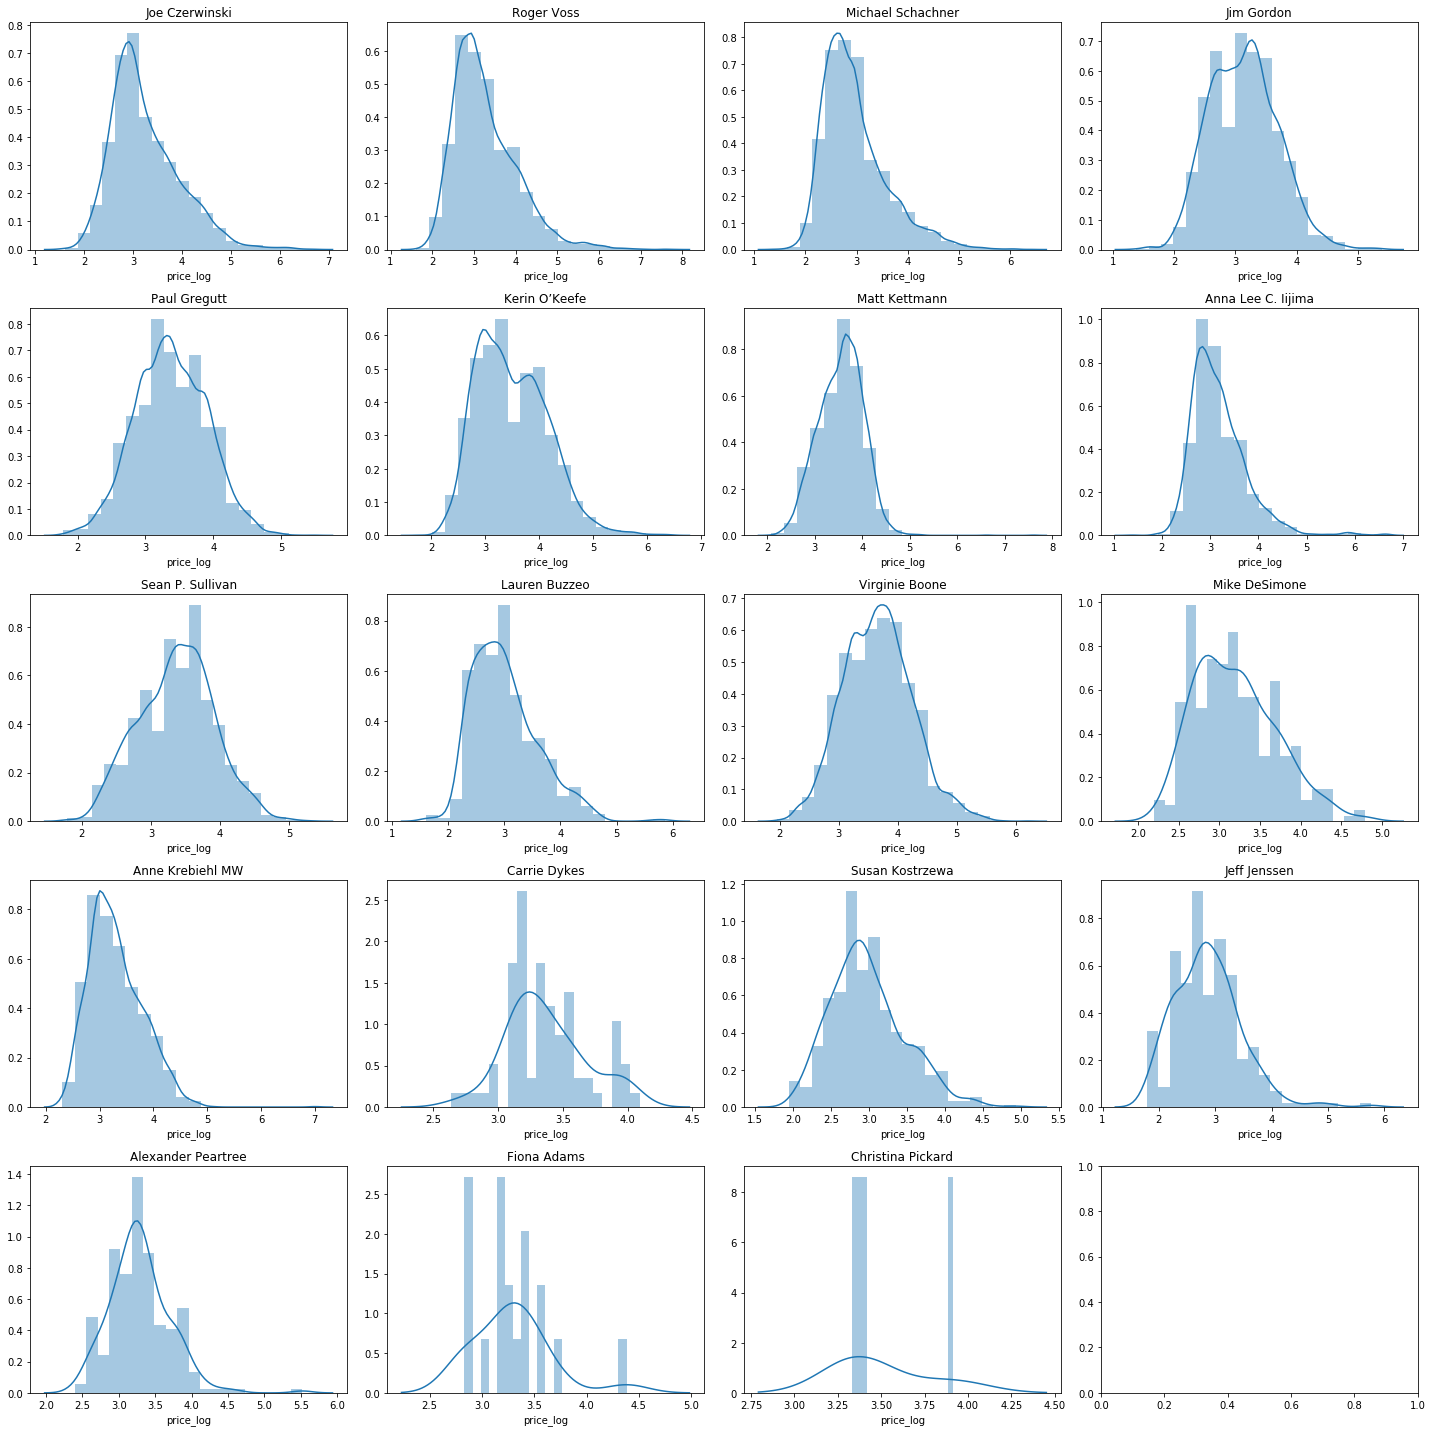

In [19]:
cols = 4
rows = math.ceil(len(tasters) / float(cols))
figs, axes = plt.subplots(rows, cols, figsize=(20,20))
axes = axes.flatten()
for taster, ax in zip(tasters, axes):
    taster_reviews = train_df[(train_df.taster_name == taster) & ~train_df.price_log.isna()]
    ax = sns.distplot(taster_reviews.price_log, ax=ax, bins=20)
    ax.set_title(taster)

plt.tight_layout()

### Unique Words
Let's look at the top 3 unique words used by the tasters. We'll do this by iteratively constructing of the top 3 words used by each taster and removing any duplicate words across top 3 lists.

In [20]:
stop_words = nltk.corpus.stopwords.words('english')

# collect the top 25 words from the corpus (not including nltk stop words)
top_domain_specific_words = []
n = 25
for word, count in counter.most_common():
    if word in stop_words:
        continue
    
    top_domain_specific_words.append(word)
    if len(top_domain_specific_words) == n:
        break
        
all_stop_words = list(string.punctuation) + top_domain_specific_words + stop_words

n = 3
top_vocab = {}
for taster_name in taster_vocabs:
    taster_vocab = taster_vocabs[taster_name]
    
    unique_words = []
    for word, count in taster_vocab.most_common():
        if word in all_stop_words:
            continue
        
        unique_words.append(word)
        if len(unique_words) == n:
            break
        
    top_vocab[taster_name] = unique_words
        
for taster_name, words in top_vocab.items():
    print(f'{taster_name}: ')
    for i, w in enumerate(words):
        print(f'\t{i+1}: {w}')

Joe Czerwinski: 
	1: hints
	2: long
	3: slightly
Roger Voss: 
	1: fruits
	2: character
	3: crisp
Michael Schachner: 
	1: plum
	2: herbal
	3: feels
Jim Gordon: 
	1: texture
	2: like
	3: full-bodied
Paul Gregutt: 
	1: light
	2: blend
	3: cabernet
Kerin O’Keefe: 
	1: offers
	2: alongside
	3: white
Matt Kettmann: 
	1: bottling
	2: shows
	3: dried
Anna Lee C. Iijima: 
	1: riesling
	2: peach
	3: apple
Sean P. Sullivan: 
	1: cabernet
	2: herb
	3: lead
Lauren Buzzeo: 
	1: plum
	2: mouth
	3: sweet
Virginie Boone: 
	1: soft
	2: cabernet
	3: texture
Mike DeSimone: 
	1: bright
	2: soft
	3: offers
Anne Krebiehl MW: 
	1: freshness
	2: lemon
	3: pear
Carrie Dykes: 
	1: long
	2: soft
	3: peach
Susan Kostrzewa: 
	1: pair
	2: white
	3: citrus
Jeff Jenssen: 
	1: lemon
	2: mouth
	3: apple
Alexander Peartree: 
	1: peach
	2: tones
	3: lemon
Fiona Adams: 
	1: cedar
	2: currant
	3: blackberry
Christina Pickard: 
	1: pinot
	2: toast
	3: silky


Let's see what words are most strongly correlated with price

In [29]:
score_vec = CountVectorizer(
    lowercase=True,
    stop_words=stop_words,
    ngram_range=(1,1),
    min_df=10
)
X_score = score_vec.fit_transform(train_df.description)

In [41]:
def get_corr(x, y):
    y = np.expand_dims(y, axis=0)
    x = x.toarray().T
    points_np = np.concatenate([x, y], axis=0)
    return np.corrcoef(points_np)[-1][:-1]

In [33]:
score_corr = get_corr(X_score, train_df.points)

Highest correlations:
	1. attitude: 0.1820834325775134
	2. bounty: 0.17652372395847893
	3. peek: 0.16757787766265167
	4. mulberries: 0.15506802595829577
	5. 25: 0.15202316256297835
	6. genre: 0.1513202303790494
	7. garganega: 0.15040985528140846
	8. chewy: 0.14352226201315016
	9. pinot: 0.13983088178246156
Lowest correlations:
	1. accompanies: -0.1829939778242171
	2. suitable: -0.10396534836525306
	3. la: -0.09729532532478292
	4. gray: -0.09243144236465649
	5. detail: -0.08992928431353497
	6. desired: -0.08838617546134264
	7. sauces: -0.0879820167058551
	8. twist: -0.08686272499140327
	9. borderline: -0.08653991341741972
	10. lover: -0.08612963925709731


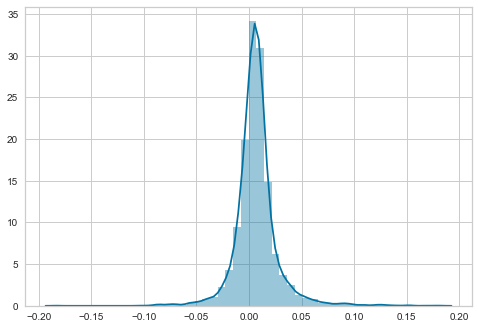

In [34]:
def display_corr(corr, vec):
    n = 10
    corr_sorted_idx = np.argsort(corr)
    vocab_words = list(vec.vocabulary_.keys())
    
    print('Highest correlations:')
    for i, idx in enumerate(corr_sorted_idx[-1:-n:-1]):
        corr_val = corr[idx]
        word = vocab_words[idx]
        print(f'\t{i+1}. {word}: {corr_val}')

    print('Lowest correlations:')
    for i, idx in enumerate(corr_sorted_idx[:n]):
        corr_val = corr[idx]
        word = vocab_words[idx]
        print(f'\t{i+1}. {word}: {corr_val}')
    
    # plot the correlations
    sorted_score_corr = score_corr[corr_sorted_idx]
    _ = sns.distplot(sorted_score_corr)
    
display_corr(score_corr, score_vec)

Let's do the same thing but for price

In [35]:
train_price_df = train_df.dropna(subset=['price'], axis=0, inplace=False)

price_vec = CountVectorizer(
    lowercase=True,
    stop_words=stop_words,
    ngram_range=(1,1),
    min_df=10
)
X_price = price_vec.fit_transform(train_price_df.description)
price_corr = get_corr(X_price, train_price_df.price)

Highest correlations:
	1. mouthwateringly: 0.14711489160565483
	2. glints: 0.1351288059558743
	3. 62: 0.12096796179205473
	4. enliven: 0.11135394178483943
	5. verdelho: 0.10787438084881977
	6. expressions: 0.09639868834409868
	7. primary: 0.09616332142887506
	8. rich: 0.09434977650278385
	9. smokiness: 0.09223792231503443
Lowest correlations:
	1. lavender: -0.065367567560064
	2. duras: -0.06411921684896389
	3. flight: -0.06321070551326698
	4. amid: -0.06316250542393637
	5. detail: -0.0625802615745264
	6. meunier: -0.06251475259167952
	7. streamlined: -0.061914313666934714
	8. da: -0.061382947358388215
	9. chewy: -0.06128891491394235
	10. breathing: -0.05882480059271812


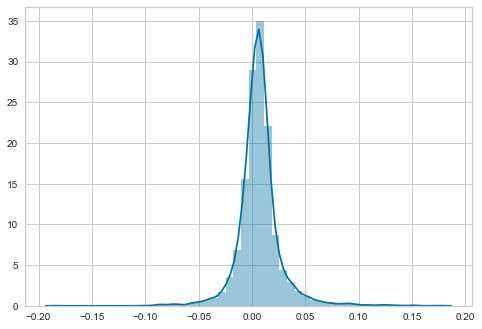

In [37]:
display_corr(price_corr, price_vec)

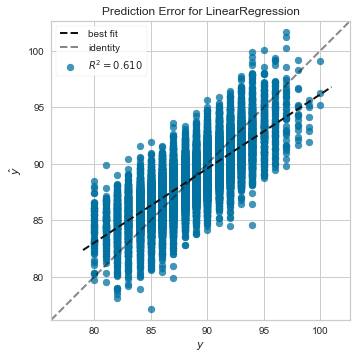

Root MSE: 1.886


In [58]:
def rmse(y_true, y_pred):
    return math.sqrt(mse(y_true, y_pred))

def train_and_show(model, x, y, x_dev, y_dev):
    visualizer = PredictionError(model)

    visualizer.fit(x, y)  # Fit the training data to the visualizer
    visualizer.score(x_dev, y_dev)  # Evaluate the model on the test data
    visualizer.poof()
    
    y_pred = visualizer.estimator.predict(x_dev)
    rmse_val = rmse(y_dev, y_pred)
    print(f'Root MSE: {rmse_val:.3f}')
    
X_score_dev = score_vec.transform(dev_df.description)

train_and_show(LinearRegression(), X_score, train_df.points, X_score_dev, dev_df.points)

/Users/austindoolittle/miniconda3/envs/jupyter3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/austindoolittle/miniconda3/envs/jupyter3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[07:41:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


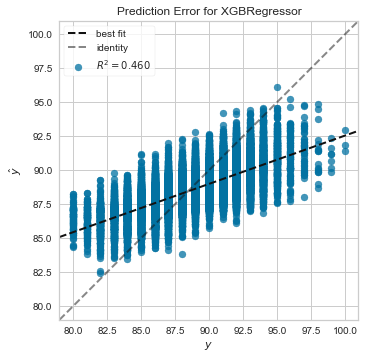

Root MSE: 2.221


In [62]:
train_and_show(XGBRegressor(max_depth=5), X_score, train_df.points, X_score_dev, dev_df.points)

Meeting Notes:
- Add Price correlation with each word in vocab
  - Make algo more memory efficient
- Visual Word Cloud
- Establish a baseline
    - Binary Classifier
    - Linear Regression on Highest and Lowest correlation words
        - Price
        - Points
- Do same analysis on Bigrams/Trigrams/NGrams
- Train new models
    - CNN approach
    - LSTM
    - BERT
    - Tasks?
        - Price Regression
        - Score Regression
        - Region Classification
        - Variety Classification
        - Sentiment analysis by Winery
- Appendix
    - Country specific
    - Region specific
    - Taster specific